# Negative Poisson Regression

As the problem is introduced and explained in file [README.md](./README.md), I proceed by presenting a brief summary regarding the key aspects of the selected methodology to build the prediction model.

**1. Prior distribution:** The target variable **"left_order_days"** ($Y$) could be seen as a count that expresses the number of events that occur within a time interval (a month in this case). This allows to assume that, from a theoretical point of view, a Poisson Distribution (formula [here](#Item-2)) could be the parametric distribution that describes the target. 

**2. Model selection:** By testing if the hypothesis above was correct, it was discovered that the target was not likely to follow a poisson distribution as $\mathbb{E}[Y] = Var(Y) = \lambda$ was not satisfied ([Apendix 1.](#Apendix-1.)). In fact it was observed that $\mathbb{E}[Y] < Var(Y)$ therefore the first model that was tested was a *Negative Binomial Regressor* (A GLM that is a generalization of a Poisson Regression that has the same link function, but deals with overdispertion adequately as explained in this [section](#2.-Model-training)). Nevertheless, after analysing the residuals of the trained *Negative Binomial Regressor*, it was observed high bias and a XGBoost model (with objective "poisson:count") was trained as a non-linear alternative in order to mitigate such an issue.

**Disclaimer:** I trained the model using a sub-sample of the training dataset due to the high computational cost of including all samples

**3. Feature engineering:** Considering that all tested models shared the same link function ($log(\lambda) = \beta X$), special attention was given to build the vector of covariates/features $X$. The intention is to include seasonal factors (ex. month of year) and clients/accounts intrinsic characteristics (ex. moving average transaction amount) that might have an effect on $\lambda$. This [section](#1.2.-Building-$X$:-Covariates/features) explains with more details the feature engieering process that was carried out.


<br><br>

**NOTEBOOK INDEX:**

[Item 1](#ITEM-1)

- [0. Package and Data imports](#0.-Package-and-Data-imports): Importing and reading the data from the disk
- [1. Target and Covariates building](#1.-Target-and-Covariates-building): Here, the first sub-section (of two) contains the code that was implemented to create the target variable **(left_order_days)** from the raw list of orders (Additional code is found in [Apendix 2.](#Apendix-2.)). Afterwards, the second sub-section contains the feature engineering process that was carried out to build $X$.
- [2. Model training](#2.-Model-training): This section contains the code that trains two models: *Negative Binomial Regression* and *XGBoost regression for poisson:count* (with hyperparameter tuning)
- [3. Model diagnosis (residual analysis)](#3.-Model-diagnosis-(residual-analysis)): Residual analysis for both models
- [4. Making predictions](#4.-Making-predictions): Building $X$ for the test set (*"august_with_missing_order_days"*) and generating the final predictions!


[Item 2](#Item-2)

- [Can you describe the distribution of the number of order days of a user(or a group of users) via a known probability distribution? Propose a formula/density function and explain your solution.](#2.a)
- [How could you estimate the parameter/s of this function?](#2.b)
- [Given the formula/density function, propose a simple way to calculate the probability of having more than 4 days of orders.](#2.c)
- [We want to estimate the time between days of orders. Propose a formula that can](#2.d)


ENJOY!

## Item 1

#### 0. Package and Data imports

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import poisson

from skopt import BayesSearchCV # bayesian optimization for hyperparameter tuning

In [2]:
# reading and preparing the data
df_historical_orders = pd.read_parquet('./historical_orders.parquet')
df_historical_orders['order_date'] = pd.to_datetime(df_historical_orders['order_date'], format="%Y-%m-%d")

df_august_with_missing_order_days = pd.read_parquet('./august_with_missing_order_days.parquet')
df_august_total_sales = pd.read_parquet('./august_total_sales.parquet')

In [3]:
df_historical_orders.head()

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


#### 1. Target and Covariates building

#### 1.1. Building the training set

Considering the target is the *order days that are left* before a month is ended, we first must transform the raw data to the adequeate format (depicted by the table below)


|account_id | month | day_of_month | further covariates ... | target|
|-----------|-------|--------------|------------------------|-------|
|BR_12345   |   07  |     14       |          ...           |   2   |
|BR_24689   |   07  |     14       |          ...           |   6   |
|BR_88888   |   07  |     14       |          ...           |   0   |
|...|||||
|BR_12345   |   07  |     28       |          ...           |   0   |
|BR_24689   |   07  |     28       |          ...           |   1   |
|BR_88888   |   07  |     28       |          ...           |   0   |
|...|||||
|BR_12345   |   08  |     11       |          ...           |   3   |
|BR_24689   |   08  |     11       |          ...           |   1   |
|BR_88888   |   08  |     11       |          ...           |   4   |

This structure ensures each user has the specific target for each day in a month


In [16]:
%%time
## TRAINING SET ##
df_train = []
i = 0
df_historical_orders['year_month'] = df_historical_orders['order_date'].dt.to_period('M')
for account_id in df_historical_orders['account_id'].unique():
    _df = df_historical_orders[df_historical_orders['account_id'] == account_id]
    _df_target = create_target(_df) ## METHOD DEFINED IN APENDIX 2.
    df_train.append(_df_target)
    i+=1
    if i>300:
        break
    
df_train = pd.concat(df_train)
df_train.head()

CPU times: user 1min 42s, sys: 77 ms, total: 1min 42s
Wall time: 1min 43s


,account_id,Date,year_month,left_order_days
0,BR_09607801000194,2021-01-01,2021-01,11
1,BR_09607801000194,2021-01-02,2021-01,10
2,BR_09607801000194,2021-01-03,2021-01,10
3,BR_09607801000194,2021-01-04,2021-01,10
4,BR_09607801000194,2021-01-05,2021-01,10


As an example of how successfully the target(left_order_days) was built based on the the list of its transactions (original data), Considering the client 'BR_09607801000194', it's possible to observe first Dataframe that shows the days the client made orders and the second dataframe that shows the days that left for any order to be executed (target).

In [430]:
id_test = 'BR_09607801000194'
print(df_historical_orders[(df_historical_orders['account_id'] == 'BR_09607801000194') & (df_historical_orders['year_month'] == '2021-01')][['order_date']].drop_duplicates().sort_values('order_date'))
print(df_train[df_train['account_id'] == 'BR_09607801000194'].head(31)[['Date','left_order_days']])

        order_date
660009  2021-01-02
1396943 2021-01-08
1375292 2021-01-09
409636  2021-01-15
1367463 2021-01-19
1381179 2021-01-22
1355645 2021-01-23
3366934 2021-01-25
654507  2021-01-27
3388738 2021-01-29
1378073 2021-01-30
         Date  left_order_days
0  2021-01-01               11
1  2021-01-02               10
2  2021-01-03               10
3  2021-01-04               10
4  2021-01-05               10
5  2021-01-06               10
6  2021-01-07               10
7  2021-01-08                9
8  2021-01-09                8
9  2021-01-10                8
10 2021-01-11                8
11 2021-01-12                8
12 2021-01-13                8
13 2021-01-14                8
14 2021-01-15                7
15 2021-01-16                7
16 2021-01-17                7
17 2021-01-18                7
18 2021-01-19                6
19 2021-01-20                6
20 2021-01-21                6
21 2021-01-22                5
22 2021-01-23                4
23 2021-01-24               

#### 1.2. Building $X$: Covariates/features

As it was already pointed out, defining $X$ adequately allows to consider seasonal factors and clients charactersitics within the regression 

**Inlcuded in $X$:**

- **day_of_month:** A numeric variable (with values between $[1,31]$) we consider is one of the main features that define $\lambda$ (rate of events). The reasoning is that the probability of having a high *left_order_days* is bigger during the first days of the month and smaller at during the final days. Therefore $\lambda$ also should vary accordingly.
- **month_of_year:** A dummy variable (12 binary columns) that accounts for seasonal effects as it's well known that some months are prone to have more orders that others.
- **transaction_amount_moving_average (3 months):** As a way to include some idiosynchartic characteristics of the clisnte behavior, I selected to include the average amount of a client's transactions of the last 3 months. This variable does not inlcude transactions of current months in order to avoid target leakage.

**Candidates of $X$:** Some other variables were thought of but deem as candidates as they are more complex to build

- **time_between_orders_moving_average:** The mean of the time a client takes between its orders. Should include the transactions of previous months relative to the month of the target in order to avoid target leakage as well.
- **Client age:** By looking at the time between the first order of an account and the current date, we might have an estimator of how old this client is relative to the transactions recorded in the dataset. As I lack business knowledge to validate whether this is a good estimator of a clients age within the company or not, I decided to leave it as a candidate.


In [17]:
%%time

## TRAINING SET ##

############ feature: transaction_amount_moving_average 3 month backwards #############
df_trans_amount_mean_by_user_and_month = df_historical_orders.groupby(['account_id','year_month']).mean('transaction_amount')
df_train_reduced_cache = df_train[['account_id','year_month']].drop_duplicates()

def get_transaction_moving_av(row, months_backwards):
    up_limit = row['year_month'] - 1
    down_limit = row['year_month'] - (months_backwards)
    return df_trans_amount_mean_by_user_and_month.loc[row['account_id']].loc[down_limit:up_limit]['transaction_amount'].mean()
    
df_train_reduced_cache['transaction_amount_moving_average'] = df_train_reduced_cache.apply(lambda row: get_transaction_moving_av(row, 3), axis = 1)
df_train = df_train.merge(df_train_reduced_cache, left_on = ['account_id','year_month'], right_on = ['account_id','year_month'], how = 'inner')

############ feature: month of year - one-hot-encoding #############
df_train['month_of_year_temp'] = df_train['Date'].dt.month
df_train = pd.concat([df_train, pd.get_dummies(df_train['month_of_year_temp'], prefix='month', dtype=int)], axis=1)
df_train = df_train.drop('month_of_year_temp', axis = 1)


############ feature: day of month #############
df_train['day_of_month'] = df_train['Date'].dt.day


# selecting X and target y
df_train = df_train[['day_of_month',
                    'transaction_amount_moving_average', 
                    'month_1',
                    'month_2',
                    'month_3',
                    'month_4',
                    'month_5',
                    'month_6',
                    'month_7',
                    'month_8',
                    'month_9',
                    'month_10',
                    'month_11',
                    'month_12',
                    'left_order_days']]
df_train = df_train.dropna()


# print final trainingset
df_train.iloc[50:70]


CPU times: user 1.62 s, sys: 75.7 ms, total: 1.69 s
Wall time: 1.72 s


,day_of_month,transaction_amount_moving_average,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,left_order_days
81,23,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,2
82,24,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,2
83,25,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,1
84,26,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,1
85,27,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,0
86,28,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,0
87,29,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,0
88,30,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,0
89,31,3720.216838,0,0,1,0,0,0,0,0,0,0,0,0,0
90,1,3988.183177,0,0,0,1,0,0,0,0,0,0,0,0,6


### 2. Model training

The target variable, from a theoretical point of view, fits with a **Poisson Distribution**. It expresses the probability of a given number of events (days order that are left) occurring in a fixed interval of time (a month). The distributions also assumes that events occur with a constant rate ($\lambda$) and each event is independent from other events (it is fair to assume that a an order is independent from previous orders). Nevertheless, one of the distribution constraints, is that the random varaible variance is equal to its expected value $\mathbb{E}[Y] = Var(Y) = \lambda$ , which is a hard condition to satisfy when working with real data.

**However, according to this [reference](https://pulmonarychronicles.com/index.php/pulmonarychronicles/article/view/200/491), when  $\mathbb{E}[Y] < Var(Y)$ it's said the data is overdispersed and using poisson regression under such circunstances lead to deflated standard error and inflated test statistics. To handle such a situation, negative binomial regression is commonly recommended.**

Whereas the Poisson distribution requires

$$\mathbb{E}[Y] = Var(Y) = \lambda$$

The negative binomial distribution has the same expected value $\lambda$ but different variance of a Poisson.

$$\mathbb{E}[Y] = \lambda$$

$$Var(Y) = \lambda + \alpha \lambda^{2}$$

Here, $\alpha$ is the parameter that accounts for the overdispertion in the data.

Considering this, the link function for either a Poisson Distribution and a Negative Binomial is the same:

$$ log(\lambda) = \beta X$$

Being $X$ a vector of covariates. Summarizing, the **link function** would look like:

$$ log(\lambda) = \beta_{0} + \beta_{1}(\text{day of month}) + \beta_{2}(\text{month of year})  + \beta_{2}(\text{average transaction amount in the past $n$ months})$$


Therefore, during the estimation (training process), let's say, using Maximum Likelihood estimators (MLE), both regressions have different likelihood functions, one considering only $\lambda$ as a function of $X$ (Poisson), and the other considering both $\lambda$ and $\alpha$ (negative binomial).


**XGBoost:** When trained using as objective *count:poisson*, it also uses the same link function ($ log(\lambda) = \beta X$) and optimizes
this loss function

$$\mathcal{L} = \sum_{i=1}^{n} \left( \lambda_i - y_i \log(\lambda_i) \right)$$

But for now, we left that estimation process to the Python libs!




#### 2.1 Training Negative Binomial Regressor

In [18]:
X = df_train[['day_of_month',
                    'transaction_amount_moving_average', 
                    'month_1',
                    'month_2',
                    'month_3',
                    'month_4',
                    'month_5',
                    'month_6',
                    'month_7',
                    'month_8',
                    'month_9',
                    'month_10',
                    'month_11',
                    'month_12']]
y = df_train['left_order_days']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Negative Binomial model
neg_binom_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()) # inferences are left for the future
neg_binom_results = neg_binom_model.fit()

# Print model summary
print(neg_binom_results.summary())

# Make predictions on the test set
y_pred = neg_binom_results.predict(X_test)
y_pred = [x if x < 30 else 30 for x in y_pred]


/Users/pecalvache/miniconda3/envs/python_3.10/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:        left_order_days   No. Observations:                85225
Model:                            GLM   Df Residuals:                    85211
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5657e+05
Date:                Wed, 25 Sep 2024   Deviance:                       39880.
Time:                        15:31:15   Pearson chi2:                 3.31e+04
No. Iterations:                    15   Pseudo R-squ. (CS):             0.3042
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
day_of

#### 2.2 Training XGBoost Regressor (count:poisson) with hyperparameter tuning using Bayesian optimization

In [19]:
xgb_reg = XGBRegressor(objective='count:poisson', booster='gbtree', n_jobs=-1, random_state=42)

# hyperparameter space
param_space = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),  
    'n_estimators': (10, 100),  
    'max_depth': (3, 10),  
    'min_child_weight': (1, 10),  
    'subsample': (0.6, 1.0), 
    'colsample_bytree': (0.6, 1.0),  
    'gamma': (0, 5),  
    'reg_lambda': (1e-3, 10, 'log-uniform'), 
    'reg_alpha': (1e-3, 10, 'log-uniform'),  
}

# Bayesian optimization cross-validation
opt = BayesSearchCV(
    estimator=xgb_reg,
    search_spaces=param_space,
    n_iter=50,  # Number of iterations for the optimization process
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the metric
    n_jobs=-1,  # Use all cores for computation
    random_state=42
)

opt.fit(X_train, y_train)
print(f"Best hyperparameters: {opt.best_params_}")


Best hyperparameters: OrderedDict([('colsample_bytree', 0.6), ('gamma', 0), ('learning_rate', 0.29999999999999993), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 100), ('reg_alpha', 0.001), ('reg_lambda', 0.001), ('subsample', 1.0)])


In [20]:
# Selected model
xgb_poisson_regressor_model = opt.best_estimator_
xgb_poisson_regressor_model.fit(X_train, y_train)

y_pred_xgboost = xgb_poisson_regressor_model.predict(X_test)
y_pred_xgboost = [x if x < 30 else 30 for x in y_pred_xgboost]

xgb_residuals = y_train - [x if x < 30 else 30 for x in xgb_poisson_regressor_model.predict(X_train)]

### 3. Model diagnosis (residual analysis)

#### 3.1 Negative Binomial Regression Diagnosis

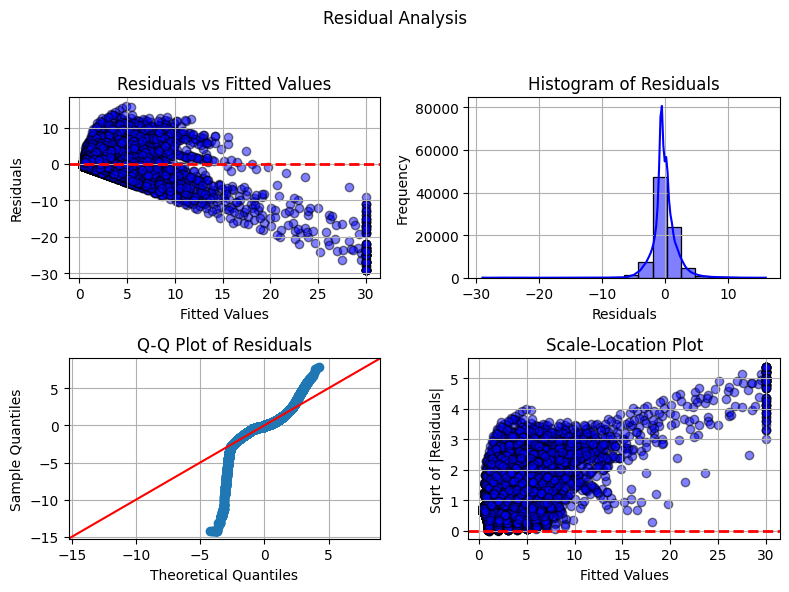

In [21]:
fitted_values = [x if x < 30 else 30 for x in neg_binom_results.predict(X_train)] 
residuals = y_train - fitted_values

plot_residuals_graphs(fitted_values, residuals, figsize = (8,6))  # METHOD DEFINED IN APENDIX 2.

According to the residuals analysis, the Negative Binomial Model presents high bias according to observations below:

- Not-normal residuals with quite heavy negative tails for large values of the target variables, which means the model overestimated the estimations for larger values
- Prescence of heteroscedasticity.

In order to tackle the high bias issue, some paths of action might include: 

- Better covariates (might help to reduce the error for larger values)
- Test other (non-linear) models that deal better with high bias

For this case, I'm going to use the XGBoost regressor with poisson:count to mitigate the high bias.



#### 3.2 XGBoost Regression Diagnosis

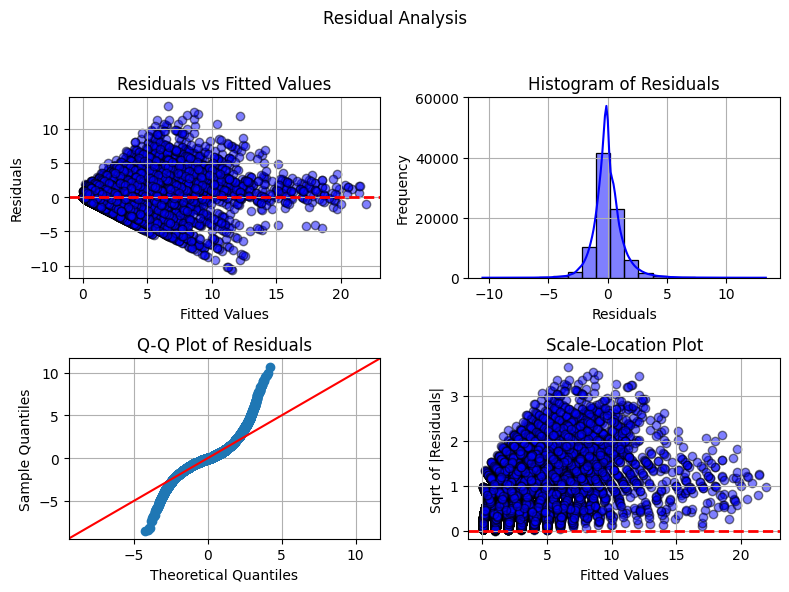

In [23]:
# xgboost with poisson objective
fitted_values = [x if x < 30 else 30 for x in xgb_poisson_regressor_model.predict(X_train)]
residuals = xgb_residuals

plot_residuals_graphs(fitted_values, residuals, figsize = (8,6))

Considering the observations of the XGBoost regressor, it is possible to observe that the high bias for **high values** (heavy negative tail) in the target was appareantly mitigated using a non-linear model.

Despite of this, there is still heteroscedasticity within the residuals distribution. This means that perhaps building and including better covariates in $X$ is one of the nexts steps to explore (hopefully) for next iterations.



### 4. Making predictions

Here, the test dataset "august_with_missing_order_days" is transformed to be fed to the model the same way it was done with the training raw data (august_total_sales.csv) but with some differences though:

As I need to set the feature **"day_of_month"**, which is (as pointed out early on) the day of the month at which we want to predict the "left_order_days" for a specific account. For instance, if the prediction for an account $a_{1}$ in August 5th is different from the prediction made in August 15th, this covariate/feature (**"day_of_month"**) represent such a date.

Knowing this, for accounts with orders in August 2022 (NOT null values), the value of **"day_of_month"** is set to be the day of the month of its last order. For accounts with no orders in August 2022 (null values), the set value is 1 (the first day of the month).

Finally, all features with **"month"** prefix, are set to $0$ except for **"month_8"** set to $1$.


In [25]:
%%time
####### Building day_of_month #######
df_august_with_missing_order_days = df_august_with_missing_order_days.fillna('2022-08-01')
df_august_with_missing_order_days['order_date'] = pd.to_datetime(df_august_with_missing_order_days['order_date'], format="%Y-%m-%d")
df_august_with_missing_order_days['day_of_month'] = df_august_with_missing_order_days['order_date'].dt.day

df_test = df_august_with_missing_order_days.groupby('account_id').max('day_of_month')
df_test['account_id'] = df_test.index
df_test.index = range(df_test.shape[0])
df_test = df_test[['account_id','day_of_month']]


############ feature: month of year - one-hot-encoding #############
for col in df_train.columns:
    if col == 'month_8':
        df_test[col] = [1 for i in range(df_test.shape[0])]
        continue
    if 'month_' in col:
        df_test[col] = [0 for i in range(df_test.shape[0])]


############### feature: transaction_amount_moving_average 3 month backwards ################
##### Using sales as proxy - it was going to require a lot to process this feature for 31k users in my local machine ######
df_trans_av_proxy = df_august_total_sales.copy()
df_trans_av_proxy['transaction_amount_moving_average'] = df_trans_av_proxy['total_transaction_amount_august']
df_trans_av_proxy = df_trans_av_proxy[['account_id','transaction_amount_moving_average']]

df_test = df_test.merge(df_trans_av_proxy, left_on = 'account_id', right_on = 'account_id', how = 'inner')
df_test.head()


CPU times: user 160 ms, sys: 9.31 ms, total: 170 ms
Wall time: 174 ms


,account_id,day_of_month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,transaction_amount_moving_average
0,BR_00000343803,1,0,0,0,0,0,0,0,1,0,0,0,0,309.99
1,BR_00001415930,1,0,0,0,0,0,0,0,1,0,0,0,0,874.98
2,BR_00001760106,1,0,0,0,0,0,0,0,1,0,0,0,0,11976.70
3,BR_00002485176,13,0,0,0,0,0,0,0,1,0,0,0,0,511.48
4,BR_00002536340,2,0,0,0,0,0,0,0,1,0,0,0,0,7081.14


In [26]:
# generating the file
X_test_final = df_test[['day_of_month',
                    'transaction_amount_moving_average', 
                    'month_1',
                    'month_2',
                    'month_3',
                    'month_4',
                    'month_5',
                    'month_6',
                    'month_7',
                    'month_8',
                    'month_9',
                    'month_10',
                    'month_11',
                    'month_12']]

# making final predictions
y_pred_final = np.round(xgb_poisson_regressor_model.predict(X_test_final))
y_pred_final = [x if x < 30 else 30 for x in y_pred_final]


# EXPORTING FINAL PREDICTIONS!
pd.DataFrame({'account_id': df_test['account_id'],'prediction':y_pred_final}).to_csv('./order_days_prediction.csv', index=False)

## Item 2


### Can you describe the distribution of the number of order days of a user (or a group of users) via a known probability distribution? Propose a formula/density function and explain your solution.

As already pointed out, the distribution that fits the best the nature of the target is the poisson distribution. Athough overdispertion is an issue as seen in some samples, **for the sake of simplicity**, I'm going to work with the poisson distribution for this theoretical exercise (aldo for item 2.b, using *Maximum Likelihood Estimator* to estimate the parameters of a binomial negative distribution, results in quite complicated math!).

The formula, or probability density distribution formula is of random variable that follows a poisson distribution is: 

$$P(Y = y | \lambda) = \frac{\lambda^y e^{-\lambda}}{y!}$$


Where

- $y$ (or $k$): Is the observed number of events. (left) days of orders in this case
- $\lambda$: Is the rate of occurrance of such events. For istance, the average number of days a client makes orders each month.

As pointed out this dsitribution requires that $\mathbb{E}[Y] = Var(Y) = \lambda$ which is rarely satisfied, but theoritcally this distribution fits the target variable as expresses the probability of a given number of events (days order that are left) occurring in a fixed interval of time (a month). The distributions also assumes that events occur with a constant rate ($\lambda$) and each event is independent from other events (it is fair to assume that an occurance of the event of interest, order, is independent from previous orders in this case)






### How could you estimate the parameter/s of this function?

Altough we already know that for a Poisson Distribution $\mathbb{E}[Y] = \lambda$, we can prove through *Maximum Likelihood Estimator* (or MLE) that this is true!

In summary, the (MLE) process consists on calculating the *Log-Likelihood function* (transforming the original *Likelihood function* using logarithms), then derive it in terms of $\lambda$ (i.e. $\frac{d}{d\lambda} \log L(\lambda) $) and equal the derivative to $0$ in order to find the values of $\lambda$ that maximizes the *Log-Likelihood function*.


#### Demonstration

Considering the definition of Likelihood Function (being $\theta$ the parameter to be estimated of a known parametric distribution):

$$L(\theta | y_1, y_2, \dots, y_n) = \prod_{i=1}^{n} P(Y = y_i | \theta)$$


We might rewrite that expression in terms of $\lambda$ and the *PDF* (probability density function):

$$L(\lambda | y_1, y_2, \dots, y_n) = \prod_{i=1}^{n} P(Y = y_i | \lambda) = \prod_{i=1}^{n} \frac{\lambda^{y_i} e^{-\lambda}}{y_i!}
$$

In order to simplify the algebra, we work with *Log-Likelihood function* instead, that allows to transform the *product* term to a *summation*


$$\log L(\lambda | y_1, y_2, \dots, y_n) = \sum_{i=1}^{n} \log \left( \frac{\lambda^{y_i} e^{-\lambda}}{y_i!} \right)$$

By simplyfing the expression even further, we end up with:

$$\log L(\lambda | y_1, y_2, \dots, y_n) = \sum_{i=1}^{n} \left( y_i \log \lambda - \lambda - \log y_i! \right)$$

And finally we manage to work with the derivatives of $\log L(\lambda)$ (equaled to $0$) to find the value of $\lambda$ that maximizes  the *Log-Likelihood function*.

$$\frac{d}{d\lambda} \log L(\lambda) = \sum_{i=1}^{n} \left( \frac{y_i}{\lambda} - 1 \right)$$

Solving for $\lambda$:

$$\sum_{i=1}^{n} \left( \frac{y_i}{\lambda} - 1 \right) = 0$$

After some algebra:

$$\hat{\lambda} = \frac{1}{n} \sum_{i=1}^{n} y_i = \bar{y} = \mathbb{E}[Y]$$

### Given the formula/density function, propose a simple way to calculate the

probability of having more than 4 days of orders. 
Given the formula/density function, propose a simple way to calculate the probability of having more than 4 days of orders.

Considering the known PDF (Poisson) and known $\hat{\lambda}$, using the Cumulative Probability Function (PDF summation/integral) we have that:

$$P(y > Y) = 1 - P(y \leq Y)$$ 

Where

$$P(y \leq Y) = \sum_{y=0}^{Y} \frac{\lambda^y e^{-\lambda}}{y!}$$

if $Y = 4$, then

$$P(y > 4 | \lambda) = 1 - P(y \leq 4| \lambda) = 1 - \sum_{y=0}^{4} \frac{\lambda^y e^{-\lambda}}{y!}$$

Now, AS AN EXAMPLE, if we suppose that $\lambda = 3$ (based on the graph below), we might get:

$$ P(y > 4 | \lambda = 3) = 1 - (0.05 + 0.15 + 0.22 + 0.22 + 0.17) = 0.83$$



### We want to estimate the time between days of orders. Propose a formula that can estimate this time.

Similar to the reasoning of selecting the poisson distribution for the current target, there is other known distribution that fits the theoretical description of "the time between days of orders". **The exponential distribution** (continuos) reflects the probability distribution of the distance between events that occur continuously and independently at a constant average rate (assumptions of a poisson distribution). Examples of random variables that follow such distribution is time between production errors. 

With this knowledge, it is possible to consider **the exponential distribution** as a prior-distribution for the current variable. The formula (PDF) then is:

$$f(y | \lambda) = \begin{cases}\lambda e^{-\lambda y}, \quad y \geq 0 \\ 0, \quad y < 0 \end{cases}$$


### Apendix 1.

Validating the target distribution using *chi square goodness of fit test*

Mean: 4.72639225181598, Variance: 9.924618034048462
p_value test: 1.8869254358330121e-134


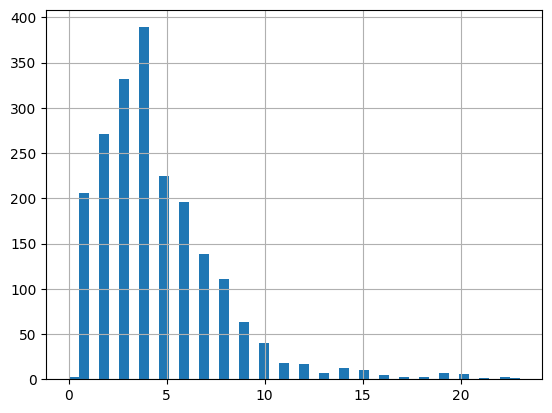

In [435]:
# sample 1: Being day_of_month == 1

sample_1 = df_train[df_train['day_of_month'] == 1]['left_order_days']
print('Mean: {}, Variance: {}'.format(sample_1.mean(), sample_1.var()))
sample_1.hist(bins=45, density = False)

# chi-square test of fitness
observed_freq, bins = np.histogram(sample_1, bins=range(0, sample_1.max()+2), density = True)

lambda_est = sample_1.mean()
expected_freq = [stats.poisson.pmf(k, lambda_est) for k in range(sample_1.max()+1)]

# Chi-square test
chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)

print('p_value test: {}'.format(p_value))

The distribution of this sample does not follow a Poisson distribution according to the p-value of the test. Furthermore, $\mathbb{E}[Y] < Var(Y)$ which is not valid for a poisson random variable.

### Apendix 2.

Methods

In [5]:
# create target
def create_target(df):
    # Create continuous date range for each user and each month
    def generate_date_range(account_id, year_month, order_dates):
        start_date = order_dates.min().replace(day=1)  # First day of the month
        end_date = order_dates.max().replace(day=pd.Period(order_dates.iloc[0].strftime('%Y-%m')).days_in_month)  # Last day of the month
        date_range = pd.date_range(start=start_date, end=end_date)
        return pd.DataFrame({'account_id': account_id, 'Date': date_range, 'year_month': year_month})

    # Calculate left order days
    def calculate_left_order_days(account_id, dates, order_days):
        order_days = sorted(order_days)  # Ensure order dates are sorted 
        left_order_days = []
        for current_date in dates:
            remaining_order_days = len([od for od in order_days if od > current_date])
            left_order_days.append(remaining_order_days)
            left_order_days
        return left_order_days
    
    # Generate date ranges for all users for each month
    all_users_date_ranges = pd.concat([
        generate_date_range(account_id, year_month, order_days_df['order_date'])
        for (account_id, year_month), order_days_df in df.groupby(['account_id', 'year_month'])
    ])
        
    # Apply the function to calculate left_order_days for each user and month
    all_users_date_ranges['left_order_days'] = all_users_date_ranges.groupby(['account_id', 'year_month'])['Date'].apply(
        lambda x: calculate_left_order_days(x.name, x, df[(df['account_id'] == x.name[0]) & (df['year_month'] == x.name[1])]['order_date'].drop_duplicates()) # sort df before by user
    ).sum()

    return all_users_date_ranges

In [6]:
# residuals analysis tools
def plot_residuals_graphs(fitted_values, residuals, figsize=(12, 10)):

    fig, axs = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Residual Analysis', fontsize=12)
    
    # 1. Residuals vs Fitted Values
    axs[0, 0].scatter(fitted_values, residuals, edgecolor='k', facecolor='blue', alpha=0.5)
    axs[0, 0].axhline(0, color='red', linestyle='--', lw=2)
    axs[0, 0].set_title('Residuals vs Fitted Values')
    axs[0, 0].set_xlabel('Fitted Values')
    axs[0, 0].set_ylabel('Residuals')
    axs[0, 0].grid(True)
    
    # 2. Histogram of Residuals
    sns.histplot(residuals, kde=True, bins=20, color='blue', ax=axs[0, 1])
    axs[0, 1].set_title('Histogram of Residuals')
    axs[0, 1].set_xlabel('Residuals')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].grid(True)
    
    # 3. Q-Q Plot (Quantile-Quantile Plot)
    sm.qqplot(residuals, line ='45', fit=True, ax=axs[1, 0])
    axs[1, 0].set_title('Q-Q Plot of Residuals')
    axs[1, 0].grid(True)
    
    # 4. Scale-Location Plot (Sqrt of Residuals vs Fitted Values)
    sqrt_abs_residuals = np.sqrt(np.abs(residuals))
    axs[1, 1].scatter(fitted_values, sqrt_abs_residuals, edgecolor='k', facecolor='blue', alpha=0.5)
    axs[1, 1].axhline(0, color='red', linestyle='--', lw=2)
    axs[1, 1].set_title('Scale-Location Plot')
    axs[1, 1].set_xlabel('Fitted Values')
    axs[1, 1].set_ylabel('Sqrt of |Residuals|')
    axs[1, 1].grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()